# INF-510, Claudio Torres, claudio.torres@usm.cl, DI-UTFSM
## Textbook: Lloyd N. Trefethen, Spectral Methods in MATLAB, SIAM, Philadelphia, 2000

# More on Spectral Matrices

In [1]:
import matplotlib.pyplot as plt # type: ignore
%matplotlib inline
import numpy as np # type: ignore
import sympy as sym # type: ignore
from scipy.linalg import toeplitz # type: ignore
# The variable M is used for changing the default size of the figures
M=8
from ipywidgets import interact # type: ignore

FS = 20
plt.rcParams.update({
    'font.size': FS,
    'text.usetex': True,
    'font.family': 'sans-serif',
    'font.sans-serif': 'Helvetica',
    'xtick.labelsize': FS,
    'ytick.labelsize': FS,
    'axes.labelsize': FS,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

sym.init_printing()

def plot_matrices_with_values(ax,M, flag_numbers=True):
    N=M.shape[0]
    cmap = plt.get_cmap('GnBu')
    ax.matshow(M, cmap=cmap)
    if flag_numbers:
        for i in np.arange(0, N):
            for j in np.arange(0, N):
                ax.text(i, j, r'${:.2f}$'.format(M[i,j]), va='center', ha='center', color='r')

## "The magical and beautiful sinc function" by ?

In [2]:
def Sh(x,h):
    if np.abs(x)<=1e-10:
        return 1.0
    else:
        y=np.pi*x/h
        return np.sin(y)/y
Shv = np.vectorize(Sh) 

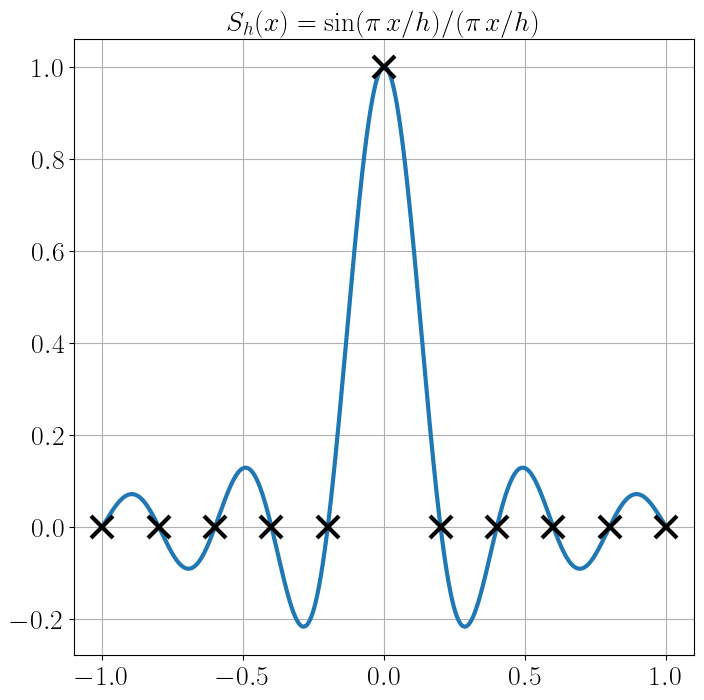

In [3]:
N=10
h=2/N
x=np.linspace(-1,1,10000)

xx=np.linspace(-1,1,N+1)
yy=np.zeros(N+1)
yy[int(N/2)]=1

plt.figure(figsize=(M,M))
plt.plot(x,Shv(x,h),'-',linewidth=3)
plt.plot(xx,yy,'kx',markersize=16,markeredgewidth=3)
plt.grid(True)
plt.title(r'$S_h(x)=\sin(\pi\,x/h)/(\pi\,x/h)$',fontsize=20)
plt.show()

## Just interpolating a few functions

In [4]:
def Interpolate_with_Sh(xx,h,N,yy,x):
    out=np.zeros(x.shape[0])
    for i in np.arange(N+1):
        out+=yy[i]*Shv(x-xx[i],h)
    return out

In [5]:
def interp_sinc(N=5):
    h=2./N
    # Variable for plotting 'continuously'
    x=np.linspace(-1,1,10000)
    # Creating the hZ mesh
    xx=np.linspace(-1,1,N+1)
    # Creating some grid functions
    yy1=1.*(np.abs(xx)<=0.3)
    yy2=(1.0-np.abs(xx)/0.3)*(1.*(1.0-np.abs(xx)/0.3>=0))

    plt.figure(figsize=(3*int(M/2),int(M/2)))

    plt.subplot(121)
    yy=yy1
    plt.plot(x,Interpolate_with_Sh(xx,h,N,yy,x),'-',linewidth=3)
    plt.plot(xx,yy,'k.',markersize=8,markeredgewidth=3, label=r'$\mathrm{data\ in\ }h\,\mathbb{Z}$')
    plt.grid(True)

    plt.subplot(122)
    yy=yy2
    plt.plot(x,Interpolate_with_Sh(xx,h,N,yy,x),'-',linewidth=3, label=r'$\mathrm{Interpolation\ with}\,S_h(x)$')
    plt.plot(xx,yy,'k.',markersize=8,markeredgewidth=3, label=r'$\mathrm{data\ in\ }h\,\mathbb{Z}$')
    plt.grid(True)
    plt.legend(loc='best', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.show()

interact(interp_sinc, N=(5,100,5));

interactive(children=(IntSlider(value=5, description='N', min=5, step=5), Output()), _dom_classes=('widget-int…

## Band limited interpolant

In [6]:
def ShBL(x,h):
    # Why do I need to do this?
    if np.abs(x)<=1e-10:
        return 1.0+(-(1./12.)-np.pi**2/(6.*h**2))*x**2
    elif np.abs(x-2*np.pi)<=1e-10:
        return 1.0+(-(1./12.)-np.pi**2/(6.*h**2))*(x-2*np.pi)**2
    else:
        y=np.pi*x/h
        return np.sin(y)/((2*np.pi/h)*np.tan(x/2))
ShBLv = np.vectorize(ShBL)

def Interpolate_with_ShBL(xx,h,N,yy,x):
    out=np.zeros(x.shape[0])
    for i in np.arange(N):
        out+=yy[i]*ShBLv(x-xx[i],h)
    return out

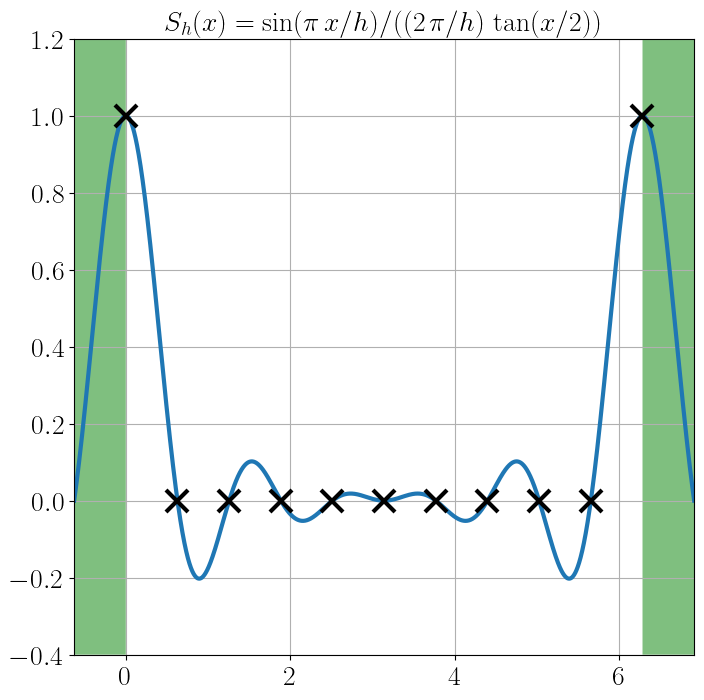

In [7]:
N=10
h=2*np.pi/N
x=np.linspace(0-h,2*np.pi+h,10000)

xx=np.linspace(0,2*np.pi,N+1)
yy=np.zeros(N+1)
yy[0]=1
yy[-1]=1

fig, ax = plt.subplots(figsize=(M,M))
ax.plot(x,ShBLv(x,h),'-',linewidth=3)
ax.plot(xx,yy,'kx',markersize=16,markeredgewidth=3)
ax.grid(True)
plt.xlim([0-h,2*np.pi+h])
plt.ylim([-0.4,1.2])
plt.title(r'$S_h(x) = \sin(\pi\,x/h)/((2\,\pi/h)\,\tan(x/2))$',fontsize=20)
# Convert boolean ndarray to a Python list of bools so type checkers accept the 'where' argument
ax.fill_between(x, y1=-0.4, y2=1.2, where=(x < 0.0).tolist(), facecolor='green', alpha=0.5)
ax.fill_between(x, y1=-0.4, y2=1.2, where=(x > 2*np.pi).tolist(), facecolor='green', alpha=0.5)
plt.show()

In [8]:
def my_D_spec(N):
    h=(2./N)*np.pi
    c=np.zeros(N)
    j=np.arange(1,N)
    c[1:]=0.5*((-1)**j)*(np.tan(j*h/2.)**(-1))
    r=np.zeros(N)
    r[0]=c[0]
    r[1:]=c[-1:0:-1]
    D=np.pi*toeplitz(c,r=r)
    return D

# This is almost the same as the previous notebook but with a 2*np.pi coefficient removed (Why?!).
def my_D_spec_2pi(N):
    h=(2./N)*np.pi
    c=np.zeros(N)
    j=np.arange(1,N)
    c[1:]=0.5*((-1)**j)*(np.tan(j*h/2.)**(-1))
    r=np.zeros(N)
    r[0]=c[0]
    r[1:]=c[-1:0:-1]
    D=toeplitz(c,r=r)
    return D

## Spectral derivative again

In [9]:
def show_spec_derivative(N=24):
    h=2.*np.pi/N
    # Variable for plotting 'continuously'
    x=np.linspace(0,2*np.pi,10000)
    # Creating the hZ mesh
    xx=np.linspace(0,2*np.pi,N+1)[1:]
    # Creating the grid functions
    yy0=1.0-np.abs(xx-np.pi)/2
    yy1=(yy0)*(1.*(yy0>=0))
    yy2=np.exp(np.sin(xx))

    D=my_D_spec_2pi(N)

    plt.figure(figsize=(M,M))

    plt.subplot(221)
    yy=yy1
    plt.plot(x,Interpolate_with_ShBL(xx,h,N,yy,x),'-',linewidth=3)
    plt.plot(xx,yy,'kx',markersize=16,markeredgewidth=3)
    plt.grid(True)

    plt.subplot(222)
    plt.plot(xx,np.dot(D,yy),'kx-',markersize=16,markeredgewidth=3,linewidth=3)
    plt.grid(True)

    plt.subplot(223)
    yy=yy2
    plt.plot(x,Interpolate_with_ShBL(xx,h,N,yy,x),'-',linewidth=3)
    plt.plot(xx,yy,'kx',markersize=16,markeredgewidth=3)
    plt.grid(True)

    plt.subplot(224)
    plt.plot(xx,np.dot(D,yy),'kx-',markersize=16,markeredgewidth=3,linewidth=3)
    error_max=np.max(np.abs(yy*np.cos(xx)-np.dot(D,yy)))
    plt.title(r'$\mathrm{max\ error=}\,'+str(error_max)+r'$',fontsize=12)
    plt.grid(True)

    plt.show()
interact(show_spec_derivative, N=(4,100,4))

interactive(children=(IntSlider(value=24, description='N', min=4, step=4), Output()), _dom_classes=('widget-in…

<function __main__.show_spec_derivative(N=24)>

## Using FFT for the same task!

In [10]:
def my_first_implementation_of_derivative_with_FFT(yy):
    N=yy.shape[0]
    # Frequencies of fft
    K=np.fft.fftfreq(N)*N
    # i*K
    iK=1j*K
    # FFT
    v_hat = np.fft.fft(yy)
    # The actual derivative in Fourier space!
    w_hat = iK*v_hat
    # Taking care of the loss of symmetry
    w_hat[int(N/2)]=0
    # Coming back to the physical space
    ww  = np.real(np.fft.ifft(w_hat))
    return ww

In [11]:
def show_spec_derivative_FFT(N=24):
    h=2.*np.pi/N
    # Variable for plotting 'continuously'
    x=np.linspace(0,2*np.pi,10000)
    # Creating the hZ mesh
    xx=np.linspace(2*np.pi/N,2*np.pi,N)
    # Creating the grid functions
    yy0=1.0-np.abs(xx-np.pi)/2
    yy1=(yy0)*(1.*(yy0>=0))
    yy2=np.exp(np.sin(xx))

    plt.figure(figsize=(M,M))

    plt.subplot(221)
    yy=yy1
    plt.plot(x,Interpolate_with_ShBL(xx,h,N,yy,x),'-.')
    plt.plot(xx,yy,'kx',markersize=16,markeredgewidth=3)
    plt.grid(True)

    plt.subplot(222)
    # Begin derivative by DFT, i.e. FFT!
    ww = my_first_implementation_of_derivative_with_FFT(yy)
    # End derivative by DFT, i.e. FFT!
    plt.plot(xx,ww,'kx-',markersize=16,markeredgewidth=3)
    plt.grid(True)

    plt.subplot(223)
    yy=yy2
    plt.plot(x,Interpolate_with_ShBL(xx,h,N,yy,x),'-.')
    plt.plot(xx,yy,'kx',markersize=16,markeredgewidth=3)
    plt.grid(True)

    plt.subplot(224)
    # Begin derivative by DFT, i.e. FFT!
    ww = my_first_implementation_of_derivative_with_FFT(yy)
    # End derivative by DFT, i.e. FFT!
    plt.plot(xx,ww,'kx-',markersize=16,markeredgewidth=3)
    error_max=np.max(np.abs(yy*np.cos(xx)-ww))
    plt.title('max error='+str(error_max), fontsize=10)
    plt.grid(True)

    plt.show()
interact(show_spec_derivative_FFT, N=(4,100,4))

interactive(children=(IntSlider(value=24, description='N', min=4, step=4), Output()), _dom_classes=('widget-in…

<function __main__.show_spec_derivative_FFT(N=24)>

# Chebyshev differentiation matrix

In [12]:
def cheb(N):
    if N==0:
        D=0
        x=1
        return D,x
    x = np.cos(np.pi*np.arange(N+1)/N)
    c=np.hstack((2,np.ones(N-1),2))*((-1.)**np.arange(N+1))
    X=np.tile(x,(N+1,1)).T
    dX=X-X.T
    D = np.outer(c,1./c)/(dX+np.eye(N+1))
    D = D - np.diag(np.sum(D.T,axis=0))
    return D,x
def show_cheb(N):
    D,x=cheb(N)
    print(x)
    # We multiply by h just to cancel out its dependency   
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2*M,M))
    # First derivative
    plot_matrices_with_values(ax1,D, flag_numbers=True)
    # 'Second' derivative
    plot_matrices_with_values(ax2,np.dot(D,D), flag_numbers=True)
    plt.show()
    
interact(show_cheb,N=(0,10,1))

interactive(children=(IntSlider(value=5, description='N', max=10), Output()), _dom_classes=('widget-interact',…

<function __main__.show_cheb(N)>

## Chebyshev differentiation

In [13]:
# Variable for plotting 'continuously'
x=np.linspace(-1,1,10000)
# The function we will be studying
u= lambda x: np.exp(x)*np.sin(5*x)
# We just computed the derivative by hand
up= lambda x: np.exp(x)*(np.sin(5*x)+np.cos(5*x)*5)

def show_cheb_diff_example(N=10):

    plt.figure(figsize=(3*M,M))

    DCheb, xCheb = cheb(N)
    # Creating the grid functions
    yy = u(xCheb)
    yyp = up(xCheb)

    plt.subplot(131)
    plt.plot(x,u(x),'-', label=r'$\mathrm{Exact}\,u(x)$', linewidth=3)
    plt.plot(xCheb,yy,'kx', markersize=16, markeredgewidth=3, label=r'$\mathrm{Data\ at\ Cheb.\ points}$')
    plt.grid(True)
    plt.legend(loc='best')
    
    plt.subplot(132)
    plt.plot(x,up(x),'-', label=r'$\mathrm{Exact}\,up(x)$', linewidth=3)
    plt.plot(xCheb,yyp,'kx', markersize=16, markeredgewidth=3, label=r'$\mathrm{Data\ der.\ at\ Cheb.\ points}$')
    plt.grid(True)
    plt.legend(loc='best')

    plt.subplot(133)
    plt.plot(xCheb,np.dot(DCheb,yy)-up(xCheb),'kx-',markersize=16,markeredgewidth=3)
    error_max=np.max(np.abs(np.dot(DCheb,yy)-up(xCheb)))
    plt.title(r'$\mathrm{max\ error}=$'+r'$'+str(error_max)+r'$')
    plt.grid(True)

    plt.show()
    
interact(show_cheb_diff_example,N=(5,100,1))

interactive(children=(IntSlider(value=10, description='N', min=5), Output()), _dom_classes=('widget-interact',…

<function __main__.show_cheb_diff_example(N=10)>

# In-class work

## Implement Program 6, 7 and 12